# Initialisation

In [ ]:
#!pip install matplotlib
!pip install scipy

from google.colab import drive
drive.mount('/content/drive/')

#dependencies
import math 
import random
import datetime
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from tqdm import tqdm

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#@markdown #Initialisation of the population
#@markdown N = number of mortals in the simulation

#@markdown ---

N = 256 #@param {type:"slider", min:16, max:16384, step:16}
I = 4096 #@param {type:"slider", min:16, max:16384, step:16}
#@markdown ---
C = 0.02 #@param {type:"slider", min:0, max:1, step:0.005}
#F = 1 #@param {type:"slider", min:0, max:1, step:0.01}
#@markdown ---
maxEfficiency = 20 #@param {type:"slider", min:1, max:50, step:1}
mutationMagnitude = 0 #@param {type:"slider", min:0, max:0.5, step:0.01}
seasonLength = 32 #@param {type:"slider", min:1, max:256, step:1}
childCost = 30 #@param {type:"slider", min:0, max:30, step:0.1}
killCost = 1 #@param {type:"slider", min:0, max:5, step:0.01}
startingWorkers = 1 #@param {type:"slider", min:0, max:32, step:1}
startingStealth = 0 #@param {type:"slider", min:0, max:1, step:0.01}
totalFood = 256 #@param {type:"slider", min:0, max:8192, step:16}
queenWeight = 20 #@param {type:"slider", min:0, max:32, step:1}
splitThreshold = 32 #@param {type:"slider", min:0, max:128, step:2}
foodReserves = 0.2 #@param {type:"slider", min:0, max:1, step:0.01}

class Ant:
  def __init__(self, _isAltruistic, _stealth, _dateOfBirth):
    self.stealth = _stealth
    self.isAltruistic = _isAltruistic
    self.dateOfBirth = _dateOfBirth
    self.saturation = 0

#colony class for keeping track of groups of ants
class Colony:
  def __init__(self, _isAltruistic, _saturation):
    self.saturation = _saturation
    self.workers = []
    for i in range(startingWorkers):
      self.workers.append(Ant(_isAltruistic, 0, 0))

    self.queens = []
    self.queens.append(Ant(_isAltruistic, random.random(), 0))
    self.isAltruistic = _isAltruistic
    self.foodCoefficient = 0
  
  def addWorkers(self, n):
    for i in range(n):
      self.workers = np.append(self.workers, Ant(self.isAltruistic, 0, iteration))


#ant class for every ant


#class queen: #What, they're just the same!? Certainly
#  def __init__(self, _isAltruistic, _stealth, _dateOfBirth):
#    self.isAltruistic = _isAltruistic
#    self.stealth = _stealth
#    self.dateOfBirth = _dateOfBirth

iterations = [] #iterations array for the x-axis of the graph
population = []

isAltruisticData = []
isNonAltruisticData = []
altruisticColonies = []
nonAltruisticColonies = []
workersPerQueen = []


#deltaPData = []
#hungerToFoodData = []


for n in range(N):
  population.append(Colony(n <= (N / 2), 10))

population = np.array(population)

# Simulation

In [ ]:
newPopulation = []
def iterate():
  global population
  global newPopulation
  totalFoodCoefficient = 1
  altruistCount = 0
  nonAltruistCount = 0
  altruistCCount = 0
  nonAltruistCCount = 0
  newPopulation = np.copy(population)

  #addWorkers()

  for n, colony in reversed(list(enumerate(population))):
    colony.saturation -= C * (queenWeight * len(colony.queens) + len(colony.workers))
    if colony.saturation <= 0:
      #newPopulation = np.delete(newPopulation, n)
      for i in range(min(len(colony.workers), math.ceil(-colony.saturation / C))) :
        colony.workers = np.delete(colony.workers, 0)
        if len(colony.workers) == 0:
          colony.queens = np.delete(colony.queens, 0)
          if len(colony.queens) == 0:
            newPopulation = np.delete(newPopulation, n)
    
    foodCoefficient = 0
    if colony.isAltruistic:
      altruistCCount += 1
    else:
      nonAltruistCCount += 1
    
    for queen in colony.queens:
      if queen.isAltruistic:
        altruistCount += 1
      else:
        nonAltruistCount += 1
    for worker in colony.workers:
      foodCoefficient += abs(min(iteration - worker.dateOfBirth, maxEfficiency))+1
      
      if worker.isAltruistic:
        altruistCount += 1
      else:
        nonAltruistCount += 1
    foodCoefficient *= random.uniform(0.5, 2.0)
    totalFoodCoefficient += foodCoefficient
    colony.foodCoefficient = foodCoefficient
  for n, colony in enumerate(population):
    colony.saturation += abs((colony.foodCoefficient / totalFoodCoefficient) * totalFood)

  if iteration % seasonLength == 0 and iteration != 0:
    addWorkers()
    reproduce()
    splitAltruists()
  isAltruisticData.append(altruistCount)
  isNonAltruisticData.append(nonAltruistCount)
  altruisticColonies.append(altruistCCount)
  nonAltruisticColonies.append(nonAltruistCCount)
  population =  np.copy(newPopulation)

def reproduce():
  global newPopulation
  global population
  newPopulation = population
  bourgeoisie = []
  for n, colony in enumerate(population):
    for i, queen in enumerate(population[n].queens):
      queen.saturation = colony.saturation / len(colony.queens)
      bourgeoisie.append(queen)
  for n, colony in enumerate(population):
    for i, queen in enumerate(population[n].queens):
      if queen.saturation > 0:
        for j in np.random.choice(bourgeoisie, int((1 - foodReserves) * queen.saturation / childCost)):
          colony.saturation -= childCost
          offspring = mate(queen, j)
          if offspring != 0:
            if (not offspring.isAltruistic) and colony.isAltruistic: #is an imposter?
              if random.uniform(0, 1) <= offspring.stealth: #starts own colony
                colony.saturation *= (1 - 0.05)
                newColony = Colony(False, 0.05 * colony.saturation)
                newColony.queens = [offspring]
                newPopulation = np.append(newPopulation, newColony)
              else: #kill imposter
                colony.saturation = colony.saturation - killCost
            else:
              colony.queens.append(offspring)
            #else:
            #  colony.workers.append(offspring)

def mate(parent1, parent2):
  isAltruistic = False
  isLethal = False
  if (not parent1.isAltruistic and not parent2.isAltruistic):
    isAltruistic = False
  elif (parent1.isAltruistic and parent2.isAltruistic):
    isAltruistic = random.random() <= 1/3
    isLethal = random.random() <= 1/4
  else:
    isAltruistic = random.random() <= 1/2
  if not isLethal:
    #output = Ant(isAltruistic, max(min(0.5*parent1.stealth + 0.5*parent2.stealth + mutationMagnitude * random.uniform(0, 1), 1), 0), iteration)
    output = Ant(isAltruistic, max(min(0.5*parent1.stealth + 0.5*parent2.stealth + mutationMagnitude * random.randrange(0, 1), 1), 0), iteration)
    output.dateOfBirth = iteration
    return output
  else:
    return 0

def addWorkers():
  global iteration
  for colony in population:
    colony.addWorkers(len(colony.queens) * 10)

def newWorker(colony):
  global iteration
  colony.workers = np.append(colony.workers, Ant(colony.isAltruistic, 0, iteration))

def splitAltruists():
  global population
  newColonies = []
  for n, colony in reversed(list(enumerate(population))):
    if colony.isAltruistic == True and colony.saturation >= splitThreshold and len(colony.queens) >= 2:
      random.shuffle(colony.workers)

      newColony = Colony(True, colony.saturation / 2)
      newColony.workers = colony.workers[0:math.floor(len(colony.workers)/2)-1]
      newColony.queens = [colony.queens[0]]
      newColonies.append(newColony)

      oldColony = Colony(True, colony.saturation / 2)
      oldColony.workers = colony.workers[math.floor(len(colony.workers)/2):]
      oldColony.queens = [colony.queens[1]]
      newColonies.append(oldColony)

      population = np.delete(population, n)
  np.append(population, newColonies)



if len(iterations) > 0:
  rangeMin = iterations[len(iterations)-1] + 1
  rangeMax = iterations[len(iterations)-1] + 1 + I
else:
  rangeMin = 0
  rangeMax = I - 1

iteration = 0
for i in tqdm(range(rangeMin, rangeMax)): # tqdm makes a fancy progressbar
  iteration = i
  iterations.append(i)
  iterate()

100%|██████████| 4095/4095 [00:40<00:00, 101.74it/s]


# Visualisation

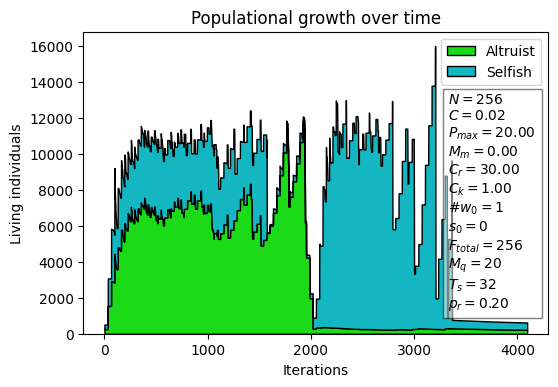

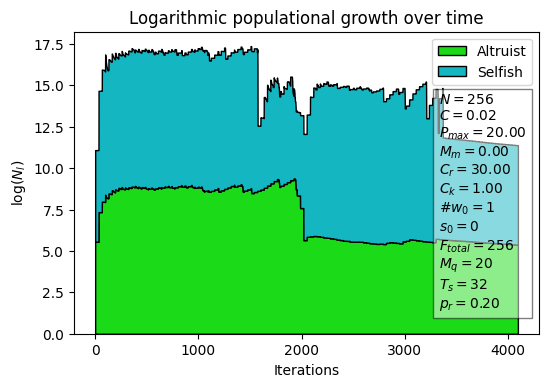

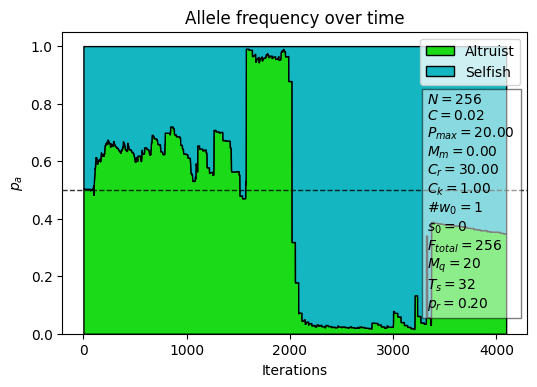

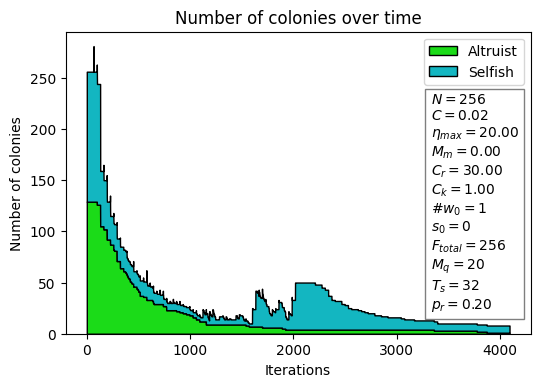

End percentage:  0.3488


In [ ]:
def formatPlot():
  plt.rcParams['figure.dpi'] = 100


palette = ['#1bdb18', '#13b6c1']
props = dict(facecolor='white', alpha=0.5)

def visualiseData():
  formatPlot()
  fig = plt.figure()
  ax = plt.axes()
  plt.title('Populational growth over time')
  plt.xlabel('Iterations')
  plt.ylabel('Living individuals')
  stacks = plt.stackplot(np.array(iterations), [np.array(isAltruisticData), np.array(isNonAltruisticData)], labels=['Altruist', 'Selfish'], alpha=1, colors=palette, edgecolor='#000000')
  
  #hatches=["//", "\\"]
  #for stack, hatch in zip(stacks, hatches):
  #  stack.set_hatch(hatch)

  plt.legend()
  textstr = textstr = '\n'.join((
    r'$N =%i$' % (N, ),
    r'$C =%.2f$' % (C, ),
    r'$P_{max} =%.2f$' % (maxEfficiency, ),
    r'$M_m =%.2f$' % (mutationMagnitude, ),
    r'$C_r =%.2f$' % (childCost, ),
    r'$C_k =%.2f$' % (killCost, ),
    r'$\# w_0 =%i$' % (startingWorkers, ),
    r'$s_0 =%i$' % (startingStealth, ),
    r'$F_{total} =%i$' % (totalFood, ),
    r'$M_q =%i$' % (queenWeight, ),
    r'$T_s =%i$' % (splitThreshold, ),
    r'$p_r =%.2f$' % (foodReserves, )))

  ax.text(0.785, 0.8, textstr, transform=ax.transAxes, verticalalignment='top', bbox=props)
  plt.savefig(f"/content/drive/My Drive/Profielwerkstuk/Output/plot7@{datetime.datetime.now()}.png", bbox_inches='tight', dpi=400)
  plt.show()


  formatPlot()
  fig = plt.figure()
  ax = plt.axes()
  plt.title('Logarithmic populational growth over time')
  plt.xlabel('Iterations')
  plt.ylabel('log($N_l$)')
  stacks = plt.stackplot(np.array(iterations), [np.array(np.log(isAltruisticData)), np.array(np.log(isNonAltruisticData))], labels=['Altruist', 'Selfish'], alpha=1, colors=palette, edgecolor='#000000')

  plt.legend()
  textstr = textstr = '\n'.join((
    r'$N =%i$' % (N, ),
    r'$C =%.2f$' % (C, ),
    r'$P_{max} =%.2f$' % (maxEfficiency, ),
    r'$M_m =%.2f$' % (mutationMagnitude, ),
    r'$C_r =%.2f$' % (childCost, ),
    r'$C_k =%.2f$' % (killCost, ),
    r'$\# w_0 =%i$' % (startingWorkers, ),
    r'$s_0 =%i$' % (startingStealth, ),
    r'$F_{total} =%i$' % (totalFood, ),
    r'$M_q =%i$' % (queenWeight, ),
    r'$T_s =%i$' % (splitThreshold, ),
    r'$p_r =%.2f$' % (foodReserves, )))

  ax.text(0.785, 0.8, textstr, transform=ax.transAxes, verticalalignment='top', bbox=props)
  #plt.savefig(f"/content/drive/My Drive/Profielwerkstuk/Output/plot7@{datetime.datetime.now()}.png", bbox_inches='tight', dpi=400)
  plt.show()


  formatPlot()
  fig = plt.figure()
  ax = plt.axes()
  plt.title('Allele frequency over time')
  plt.xlabel('Iterations')
  plt.ylabel('$p_a$')
  plt.axhline(y=0.5, color='black', linestyle='--', linewidth=1, alpha=0.8)
  isAltruisticPercentageData = []
  isNonAltruisticPercentageData = []
  for i in iterations:
    if isAltruisticData[i] + isNonAltruisticData[i] > 0:
      isAltruisticPercentageData.append(isAltruisticData[i] / (isAltruisticData[i] + isNonAltruisticData[i]))
      isNonAltruisticPercentageData.append(isNonAltruisticData[i] / (isAltruisticData[i] + isNonAltruisticData[i]))
    else:
      isAltruisticPercentageData.append(0)
      isNonAltruisticPercentageData.append(0)
      
  plt.stackplot(np.array(iterations), [np.array(isAltruisticPercentageData), np.array(isNonAltruisticPercentageData)], labels=['Altruist', 'Selfish'], alpha=1, colors=palette, edgecolor='#000000')

  plt.legend();
  textstr = textstr = '\n'.join((
    r'$N =%i$' % (N, ),
    r'$C =%.2f$' % (C, ),
    r'$P_{max} =%.2f$' % (maxEfficiency, ),
    r'$M_m =%.2f$' % (mutationMagnitude, ),
    r'$C_r =%.2f$' % (childCost, ),
    r'$C_k =%.2f$' % (killCost, ),
    r'$\# w_0 =%i$' % (startingWorkers, ),
    r'$s_0 =%i$' % (startingStealth, ),
    r'$F_{total} =%i$' % (totalFood, ),
    r'$M_q =%i$' % (queenWeight, ),
    r'$T_s =%i$' % (splitThreshold, ),
    r'$p_r =%.2f$' % (foodReserves, )))

  ax.text(0.785, 0.8, textstr, transform=ax.transAxes, verticalalignment='top', bbox=props)
  plt.savefig(f"/content/drive/My Drive/Profielwerkstuk/Output/plot8@{datetime.datetime.now()}.png", bbox_inches='tight', dpi=400)
  plt.show()

  formatPlot()
  fig = plt.figure()
  ax = plt.axes()
  plt.title('Number of colonies over time')
  plt.xlabel('Iterations')
  plt.ylabel('Number of colonies')
  plt.stackplot(np.array(iterations), [np.array(altruisticColonies), np.array(nonAltruisticColonies)], labels=['Altruist', 'Selfish'], alpha=1, colors=palette, edgecolor='#000000')
  plt.legend()
  textstr = textstr = '\n'.join((
    r'$N =%i$' % (N, ),
    r'$C =%.2f$' % (C, ),
    r'$\eta_{max} =%.2f$' % (maxEfficiency, ),
    r'$M_m =%.2f$' % (mutationMagnitude, ),
    r'$C_r =%.2f$' % (childCost, ),
    r'$C_k =%.2f$' % (killCost, ),
    r'$\# w_0 =%i$' % (startingWorkers, ),
    r'$s_0 =%i$' % (startingStealth, ),
    r'$F_{total} =%i$' % (totalFood, ),
    r'$M_q =%i$' % (queenWeight, ),
    r'$T_s =%i$' % (splitThreshold, ),
    r'$p_r =%.2f$' % (foodReserves, )))
  
  #SEASON LENGTH OMW AAGHGH

  ax.text(0.785, 0.8, textstr, transform=ax.transAxes, verticalalignment='top', bbox=props)
  plt.savefig(f"/content/drive/My Drive/Profielwerkstuk/Output/plot7@{datetime.datetime.now()}.png", bbox_inches='tight', dpi=400)
  plt.show()

  print("End percentage: ", isAltruisticPercentageData[len(isAltruisticPercentageData) - 1])

visualiseData()